<a href="https://colab.research.google.com/github/malakHelmy/Neurithm/blob/main/Neurithm_AR_Words_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install mne
!pip install mne-icalabel
!pip install keras-tuner


In [34]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Constants
FS = 128  # Sampling frequency
METADATA_COLUMNS =  [
    'EEG.Counter', 'EEG.Interpolated', 'EEG.RawCq', 'EEG.Battery',
    'EEG.BatteryPercent', 'EEG.MarkerHardware'
]

print("Libraries imported and constants initialized.")

Libraries imported and constants initialized.


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Function to combine participant CSVs for each word folder and store in a dictionary
def load_and_combine_participants(root_folder):
    combined_data = {}  # Dictionary to store combined data for each word

    for word_folder in os.listdir(root_folder):
        word_path = os.path.join(root_folder, word_folder)
        if not os.path.isdir(word_path):
            print(f"Skipping {word_path} (not a directory)")
            continue

        print(f"Processing word folder: {word_folder}")
        participant_data = []  # List to hold DataFrames for each participant

        for file in os.listdir(word_path):
            file_path = os.path.join(word_path, file)
            if not os.path.isfile(file_path) or not file.endswith('.csv'):
                print(f"  Skipping {file} (not a .csv file)")
                continue

            print(f"  Reading participant file: {file}")
            try:
                # Skip the first row while reading the CSV
                df = pd.read_csv(file_path, skiprows=1)

                # Use regular expression to extract the participant name (e.g., 'par.1', 'par.2')
                match = re.match(r'(par\.\d+)', file)
                if match:
                    participant_name = match.group(0)  # Extract the full participant name (e.g., 'par.1')
                    print(f"  Assigning participant name: {participant_name}")  # Debugging line
                    df['Participant'] = participant_name  # Add the participant name to the DataFrame
                else:
                    print(f"  No match for participant in filename: {file}")

                participant_data.append(df)
            except Exception as e:
                print(f"  Error reading {file_path}: {e}")
                continue

        # Combine all participant data into a single DataFrame for the word
        if participant_data:
            combined_df = pd.concat(participant_data, ignore_index=True)
            combined_data[word_folder] = combined_df
            print(f"  Combined data for {word_folder} loaded successfully.")
        else:
            print(f"  No valid participant files found in {word_folder}.")

    return combined_data

# Example usage
ROOT_FOLDER = r"/content/drive/MyDrive/كلمات"

# Load the data
word_data = load_and_combine_participants(ROOT_FOLDER)

# Example check: Access combined data for a specific word
if 'ء' in word_data:
    print(f"Data for word ء:\n{word_data['ء']}")


Processing word folder: نعم
  Reading participant file: par.10 نعم_EPOCX_206412_2023.12.25T13.34.07+03.00.md.csv
  Assigning participant name: par.10
  Reading participant file: par.18 نعم_EPOCX_206412_2023.12.24T10.19.29+03.00.md.csv
  Assigning participant name: par.18
  Reading participant file: par.7 نعم_EPOCX_206412_2023.12.24T12.16.14+03.00.md.csv
  Assigning participant name: par.7
  Reading participant file: par.3 نعم_EPOCX_206412_2023.12.24T10.55.23+03.00.md.csv
  Assigning participant name: par.3
  Reading participant file: par.8 نعم_EPOCX_206412_2023.12.24T11.24.36+03.00.md.csv
  Assigning participant name: par.8
  Reading participant file: par.13 نعم_EPOCX_206412_2023.12.25T14.40.12+03.00.md.csv
  Assigning participant name: par.13
  Reading participant file: par.5 نعم_EPOCX_206412_2023.12.25T12.02.19+03.00.md.csv
  Assigning participant name: par.5
  Reading participant file: par.21 نعم_EPOCX_206412_2023.12.21T15.19.38+03.00.md.csv
  Assigning participant name: par.21
  Re

In [37]:
# Function to validate EEG data for a DataFrame
def validate_eeg_data(df):
    # Define columns that start with "EEG." and are not in metadata columns
    valid_columns = [col for col in df.columns if col.startswith('EEG.') and col not in METADATA_COLUMNS]

    if not valid_columns:
        print(f"No valid EEG signal columns identified. Skipping this DataFrame.")
        return None, None  # Return None for both validated data and valid columns

    print(f"Validating data with shape: {df.shape}")
    return df[valid_columns].copy(), valid_columns  # Return DataFrame with valid columns

# Process word_data to validate EEG data for each word
validated_word_data = {}
valid_columns_map = {}  # To store valid columns for each word

for word, data in word_data.items():
    print(f"Processing data for word: {word}")
    validated_data, valid_columns = validate_eeg_data(data)  # Validate the EEG data
    if validated_data is not None:
        validated_word_data[word] = validated_data  # Store the validated data
        valid_columns_map[word] = valid_columns  # Store valid columns for this word
    else:
        print(f"  No valid EEG data for word: {word}")

Processing data for word: نعم
Validating data with shape: (30655, 69)
Processing data for word: حمام
Validating data with shape: (31761, 69)
Processing data for word: يمين
Validating data with shape: (31847, 69)
Processing data for word: جوع
Validating data with shape: (29291, 69)
Processing data for word: مسافة
Validating data with shape: (28137, 69)
Processing data for word: يسار
Validating data with shape: (34747, 69)
Processing data for word: عطش
Validating data with shape: (31913, 69)
Processing data for word: حذف
Validating data with shape: (28868, 69)
Processing data for word: لا
Validating data with shape: (30675, 69)
Processing data for word: دواء
Validating data with shape: (33337, 69)
Processing data for word: تشغيل
Validating data with shape: (30618, 69)
Processing data for word: ايقاف تشغيل
Validating data with shape: (32055, 69)
Processing data for word: اعلى
Validating data with shape: (31939, 69)
Processing data for word: اختر
Validating data with shape: (32014, 69)
Pro

In [38]:
# Function to detect bad channels
def detect_bad_channels(eeg_data, valid_columns, z_threshold=3.0):
    bad_channels = []
    channel_variances = eeg_data.var(axis=0)
    z_scores = (channel_variances - channel_variances.mean()) / channel_variances.std()

    for idx, z in enumerate(z_scores):
        if abs(z) > z_threshold:
            bad_channels.append(valid_columns[idx])

    print(f"Detected bad channels: {bad_channels}")
    return bad_channels

# Function to clean specified bad channels
def clean_bad_channels(eeg_data, bad_channels):
    if bad_channels:
        eeg_data_cleaned = eeg_data.drop(columns=bad_channels)
        print(f"Dropped bad channels: {bad_channels}")
    else:
        eeg_data_cleaned = eeg_data.copy()
        print("No bad channels to remove.")

    print(f"Shape after cleaning: {eeg_data_cleaned.shape}")
    return eeg_data_cleaned

# Consolidate bad channels from all words and clean data
def process_all_words(validated_word_data, z_threshold=3.0):
    all_bad_channels = set()
    cleaned_word_data = {}

    for word, eeg_data in validated_word_data.items():
        print(f"\nProcessing word: {word}")

        # Detect bad channels for the current word
        valid_columns = eeg_data.columns
        word_bad_channels = detect_bad_channels(eeg_data, valid_columns, z_threshold)

        # Add detected bad channels to the consolidated list
        all_bad_channels.update(word_bad_channels)

        print(f"Finished processing word: {word}")

    # Convert set to list for further processing
    all_bad_channels = list(all_bad_channels)
    print(f"\nConsolidated bad channels across all words: {all_bad_channels}")

    # Remove consolidated bad channels from all words
    for word, eeg_data in validated_word_data.items():
        print(f"\nCleaning word: {word}")
        cleaned_word_data[word] = clean_bad_channels(eeg_data, all_bad_channels)

    print("\nFinished cleaning all words.")
    return cleaned_word_data, all_bad_channels

# Example usage
# Replace `validated_word_data` with your actual dictionary of EEG data for words
# Example structure: {'A': eeg_data_A, 'B': eeg_data_B, ...}

cleaned_word_data, consolidated_bad_channels = process_all_words(validated_word_data)
print("Final cleaned data and consolidated bad channels are ready for use.")



Processing word: نعم
Detected bad channels: []
Finished processing word: نعم

Processing word: حمام
Detected bad channels: ['EEG.O1']
Finished processing word: حمام

Processing word: يمين
Detected bad channels: ['EEG.T8']
Finished processing word: يمين

Processing word: جوع
Detected bad channels: []
Finished processing word: جوع

Processing word: مسافة
Detected bad channels: []
Finished processing word: مسافة

Processing word: يسار
Detected bad channels: []
Finished processing word: يسار

Processing word: عطش
Detected bad channels: []
Finished processing word: عطش

Processing word: حذف
Detected bad channels: []
Finished processing word: حذف

Processing word: لا
Detected bad channels: []
Finished processing word: لا

Processing word: دواء
Detected bad channels: ['EEG.O1']
Finished processing word: دواء

Processing word: تشغيل
Detected bad channels: ['EEG.F3']
Finished processing word: تشغيل

Processing word: ايقاف تشغيل
Detected bad channels: []
Finished processing word: ايقاف تشغيل

P

In [39]:
# Function to create an MNE Raw object
def create_raw_object(eeg_data):
    data = eeg_data.to_numpy().T
    ch_names = eeg_data.columns.tolist()
    info = mne.create_info(ch_names=ch_names, sfreq=FS, ch_types=['eeg'] * len(ch_names))
    raw = mne.io.RawArray(data, info)
    print("Created MNE Raw object.")
    return raw

# Filter rename_dict to exclude bad channels
def filter_rename_dict(rename_dict, bad_channels):
    return {key: value for key, value in rename_dict.items() if key not in bad_channels}

# Dictionary to store Raw objects for each word
raw_word_data = {}

# Process cleaned data for each word to create Raw objects
for word, cleaned_data in cleaned_word_data.items():
    print(f"\nCreating MNE Raw object for word: {word}")

    # Create MNE Raw object from cleaned EEG data
    try:
        raw_object = create_raw_object(cleaned_data)

        # Rename channels for compatibility with standard montage
        rename_dict = {
            'EEG.AF3': 'AF3', 'EEG.AF4': 'AF4', 'EEG.F7': 'F7',
            'EEG.F3': 'F3', 'EEG.FC5': 'FC5', 'EEG.T7': 'T7',
            'EEG.P7': 'P7', 'EEG.O1': 'O1', 'EEG.O2': 'O2',
            'EEG.P8': 'P8', 'EEG.T8': 'T8', 'EEG.FC6': 'FC6',
            'EEG.F4': 'F4', 'EEG.F8': 'F8'
        }

        # Filter out bad channels from rename_dict
        filtered_rename_dict = filter_rename_dict(rename_dict, consolidated_bad_channels)

        raw_object.rename_channels(filtered_rename_dict)
        raw_word_data[word] = raw_object
        print(f"Successfully created Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to create Raw object for word {word}: {e}")



Creating MNE Raw object for word: نعم
Creating RawArray with float64 data, n_channels=11, n_times=30655
    Range : 0 ... 30654 =      0.000 ...   239.484 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for word: نعم

Creating MNE Raw object for word: حمام
Creating RawArray with float64 data, n_channels=11, n_times=31761
    Range : 0 ... 31760 =      0.000 ...   248.125 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for word: حمام

Creating MNE Raw object for word: يمين
Creating RawArray with float64 data, n_channels=11, n_times=31847
    Range : 0 ... 31846 =      0.000 ...   248.797 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for word: يمين

Creating MNE Raw object for word: جوع
Creating RawArray with float64 data, n_channels=11, n_times=29291
    Range : 0 ... 29290 =      0.000 ...   228.828 secs
Ready.
Created MNE Raw object.
Successfully created Raw object for word: جوع

Creating MNE Raw object for word: مسافة
Cre

In [40]:
# Apply filters and referencing to the Raw objects
def apply_filters_and_reference(raw):
    raw.notch_filter(freqs=50.0)
    raw.filter(l_freq=1.0, h_freq=50.0)
    raw.set_eeg_reference('average', projection=True)
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    print("Applied filters and average referencing.")
    return raw

# Perform ICA and clean artifacts for each Raw object
def perform_ica(raw, brain_threshold=0.5):
    ica = ICA(method='infomax', fit_params={'extended': True}, n_components=11, max_iter=1000)
    ica.fit(raw)
    ic_labels = label_components(raw, ica, method="iclabel")

    non_brain_components = [
        idx for idx, (label, prob) in enumerate(zip(ic_labels['labels'], ic_labels['y_pred_proba']))
        if label != 'brain' or prob < brain_threshold
    ]
    ica.exclude = non_brain_components
    raw_cleaned = ica.apply(raw)
    print(f"Excluded components: {non_brain_components}")
    return raw_cleaned


# Function to check and clean NaN/Inf values from raw data
def clean_nan_inf(raw):
    # Check for NaN/Inf in the data
    data = raw.get_data()
    if np.isnan(data).any() or np.isinf(data).any():
        print("Detected NaN or Inf values in the data.")
        # Replace NaN/Inf with the mean of the channel (or use interpolation)
        for i in range(data.shape[0]):  # Iterate over channels
            channel_data = data[i, :]
            if np.isnan(channel_data).any() or np.isinf(channel_data).any():
                channel_mean = np.nanmean(channel_data)
                channel_data[np.isnan(channel_data)] = channel_mean
                channel_data[np.isinf(channel_data)] = channel_mean
                data[i, :] = channel_data
        print("Replaced NaN/Inf values with channel mean.")
    else:
        print("No NaN or Inf values detected.")
    raw._data = data  # Update the raw object
    return raw

# Dictionary to store the cleaned Raw objects after applying filters and ICA
cleaned_raw_word_data = {}

# Updated processing loop
for word, raw_object in raw_word_data.items():
    print(f"\nProcessing Raw object for word: {word}")

    try:
        # Apply filters and reference
        filtered_and_referenced_raw = apply_filters_and_reference(raw_object)

        # Clean NaN/Inf values
        cleaned_raw = clean_nan_inf(filtered_and_referenced_raw)

        # Perform ICA and clean artifacts
        cleaned_raw = perform_ica(cleaned_raw)

        # Store the cleaned Raw object
        cleaned_raw_word_data[word] = cleaned_raw
        print(f"Successfully processed and cleaned Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to process Raw object for word {word}: {e}")




Processing Raw object for word: نعم
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequ

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 2, 3, 5, 6, 9]
Successfully processed and cleaned Raw object for word: نعم

Processing Raw object for word: حمام
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 2, 4, 8]
Successfully processed and cleaned Raw object for word: حمام

Processing Raw object for word: يمين
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pa

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 2, 5, 8, 9]
Successfully processed and cleaned Raw object for word: يمين

Processing Raw object for word: جوع
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 4 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 4, 6, 9]
Successfully processed and cleaned Raw object for word: جوع

Processing Raw object for word: مسافة
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass,

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 8 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 3, 4, 5, 6, 7, 9]
Successfully processed and cleaned Raw object for word: مسافة

Processing Raw object for word: يسار
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designin

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 3, 5, 6, 9]
Successfully processed and cleaned Raw object for word: يسار

Processing Raw object for word: عطش
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pas

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 3, 4, 6]
Successfully processed and cleaned Raw object for word: عطش

Processing Raw object for word: حذف
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 2, 6, 7]
Successfully processed and cleaned Raw object for word: حذف

Processing Raw object for word: لا
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass,

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 2, 4, 5, 6, 8]
Successfully processed and cleaned Raw object for word: لا

Processing Raw object for word: دواء
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 3, 4, 5, 9]
Successfully processed and cleaned Raw object for word: دواء

Processing Raw object for word: تشغيل
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a on

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 2, 5, 7]
Successfully processed and cleaned Raw object for word: تشغيل

Processing Raw object for word: ايقاف تشغيل
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing 

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 3, 5, 10]
Successfully processed and cleaned Raw object for word: ايقاف تشغيل

Processing Raw object for word: اعلى
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing 

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 5, 6, 7, 9]
Successfully processed and cleaned Raw object for word: اعلى

Processing Raw object for word: اختر
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 6 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 2, 4, 6, 10]
Successfully processed and cleaned Raw object for word: اختر

Processing Raw object for word: اسفل
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a on

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 1, 3, 6, 7]
Successfully processed and cleaned Raw object for word: اسفل

Processing Raw object for word: انذار
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-p

<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
<ipython-input-40-18beb32082e2>:16: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 5 ICA components
    Projecting back using 11 PCA components
Excluded components: [0, 2, 4, 5, 7]
Successfully processed and cleaned Raw object for word: انذار



Processing Raw object for word: نعم
Setting channel interpolation method to {'eeg': 'spline'}.


<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


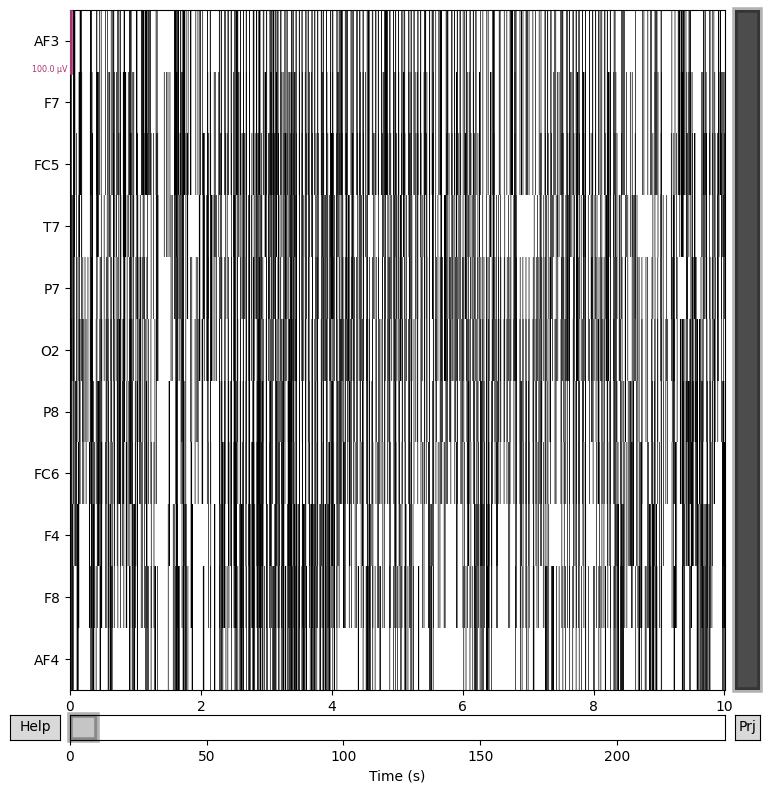

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
30650  False  False  False  False  False  False  False  False  False  False   
30651  False  False  False  False  False  False  False  False  False  False   
30652  False  False  False  False  False  False  False  False  False  False   
30653  False  False  False  False  False  False  False  False  False  False   
30654  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


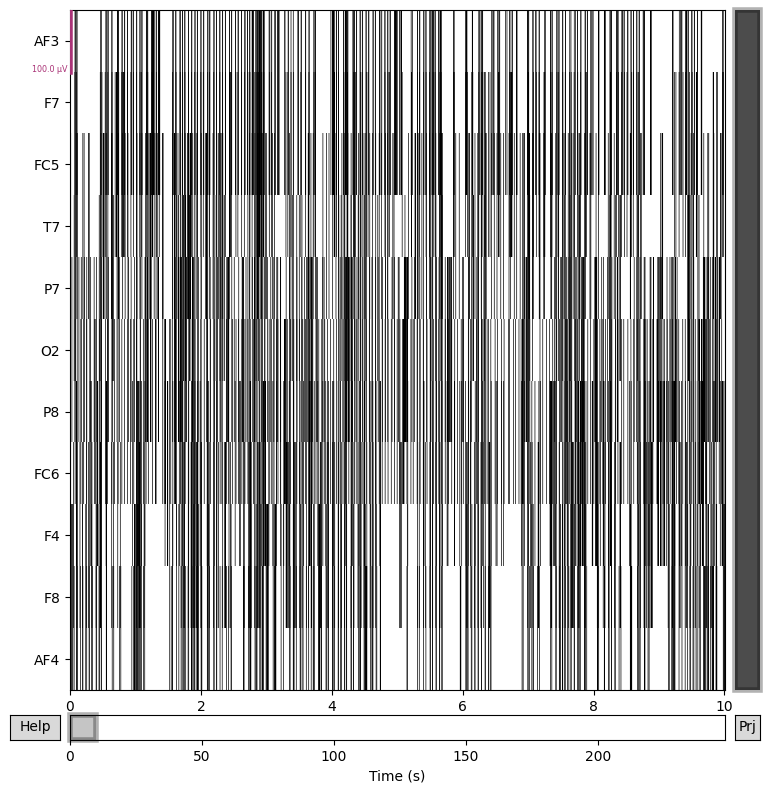

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
31756  False  False  False  False  False  False  False  False  False  False   
31757  False  False  False  False  False  False  False  False  False  False   
31758  False  False  False  False  False  False  False  False  False  False   
31759  False  False  False  False  False  False  False  False  False  False   
31760  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


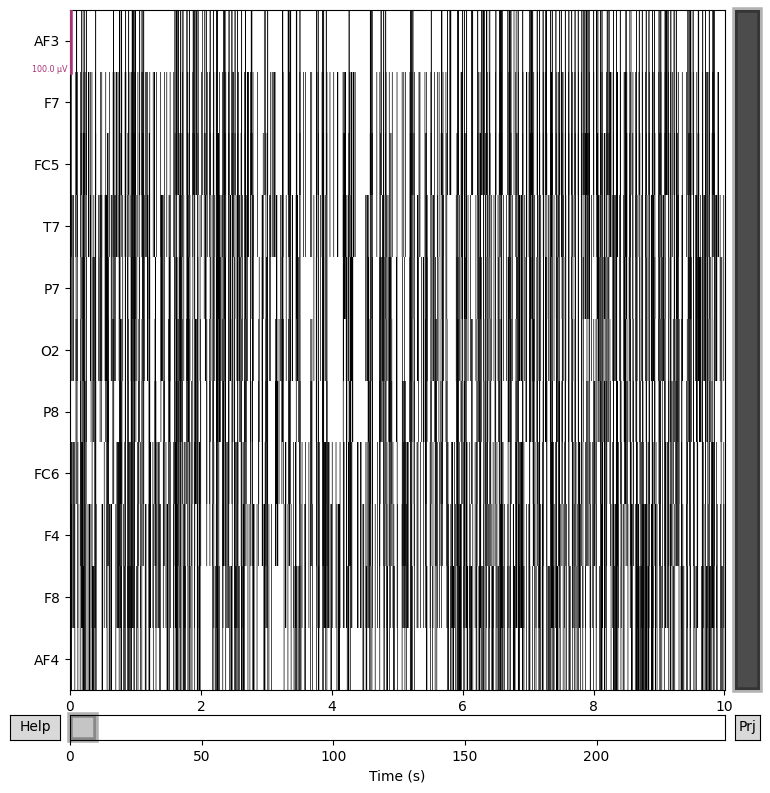

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
31842  False  False  False  False  False  False  False  False  False  False   
31843  False  False  False  False  False  False  False  False  False  False   
31844  False  False  False  False  False  False  False  False  False  False   
31845  False  False  False  False  False  False  False  False  False  False   
31846  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


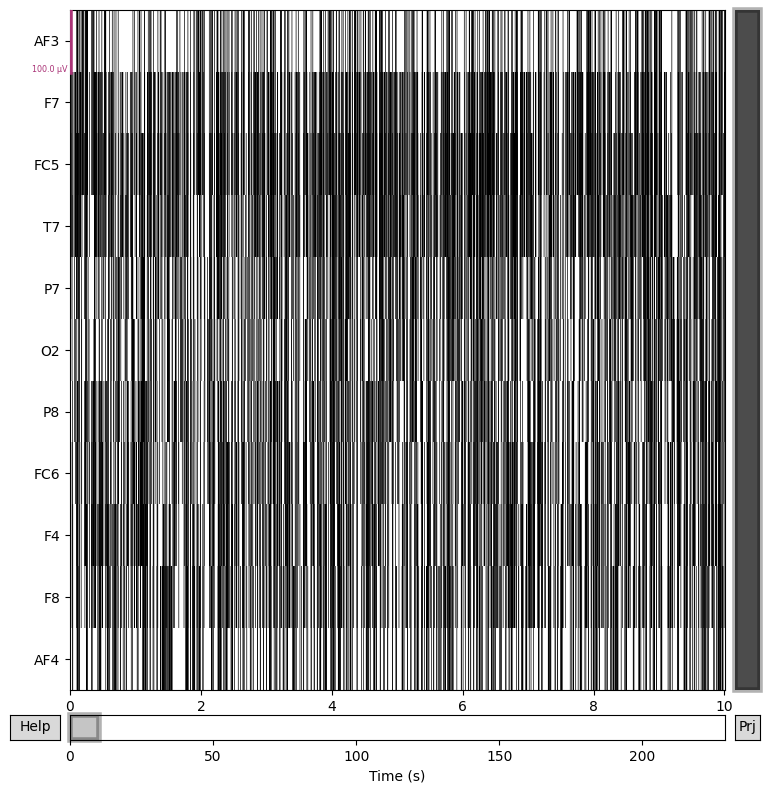

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
29286  False  False  False  False  False  False  False  False  False  False   
29287  False  False  False  False  False  False  False  False  False  False   
29288  False  False  False  False  False  False  False  False  False  False   
29289  False  False  False  False  False  False  False  False  False  False   
29290  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


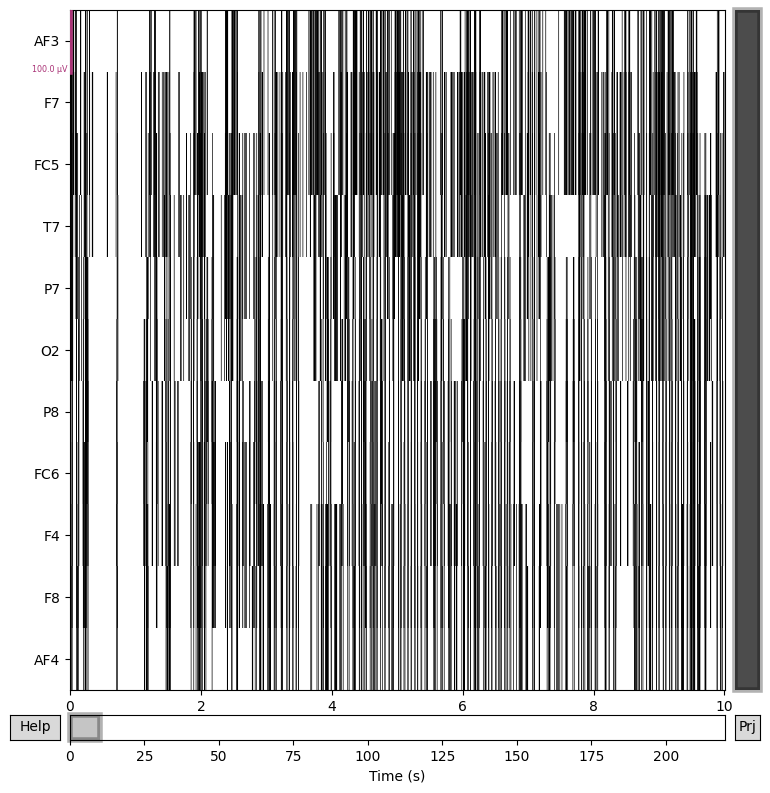

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
28132  False  False  False  False  False  False  False  False  False  False   
28133  False  False  False  False  False  False  False  False  False  False   
28134  False  False  False  False  False  False  False  False  False  False   
28135  False  False  False  False  False  False  False  False  False  False   
28136  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


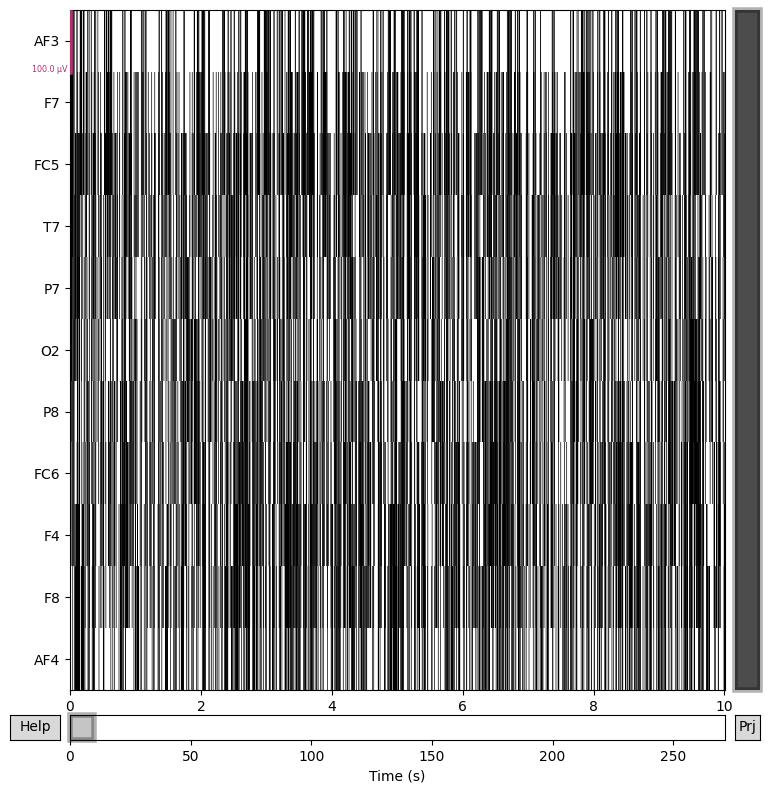

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
34742  False  False  False  False  False  False  False  False  False  False   
34743  False  False  False  False  False  False  False  False  False  False   
34744  False  False  False  False  False  False  False  False  False  False   
34745  False  False  False  False  False  False  False  False  False  False   
34746  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


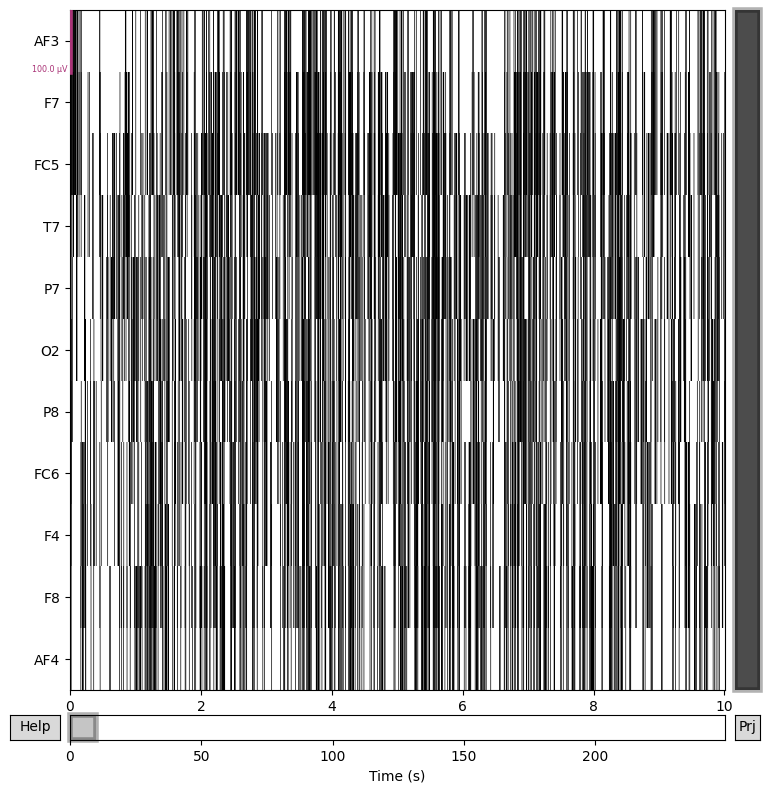

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
31908  False  False  False  False  False  False  False  False  False  False   
31909  False  False  False  False  False  False  False  False  False  False   
31910  False  False  False  False  False  False  False  False  False  False   
31911  False  False  False  False  False  False  False  False  False  False   
31912  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


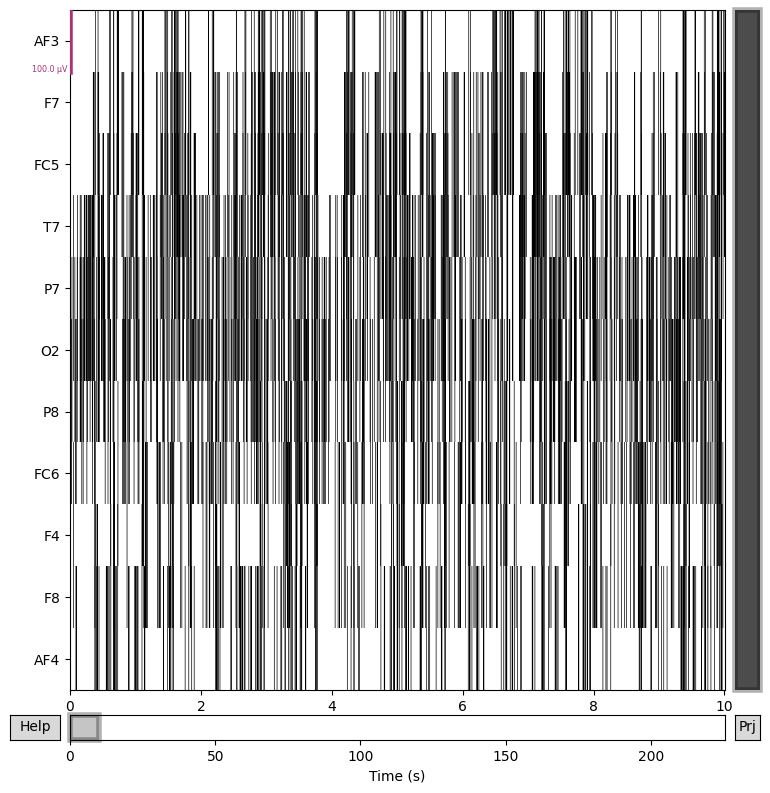

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
28863  False  False  False  False  False  False  False  False  False  False   
28864  False  False  False  False  False  False  False  False  False  False   
28865  False  False  False  False  False  False  False  False  False  False   
28866  False  False  False  False  False  False  False  False  False  False   
28867  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


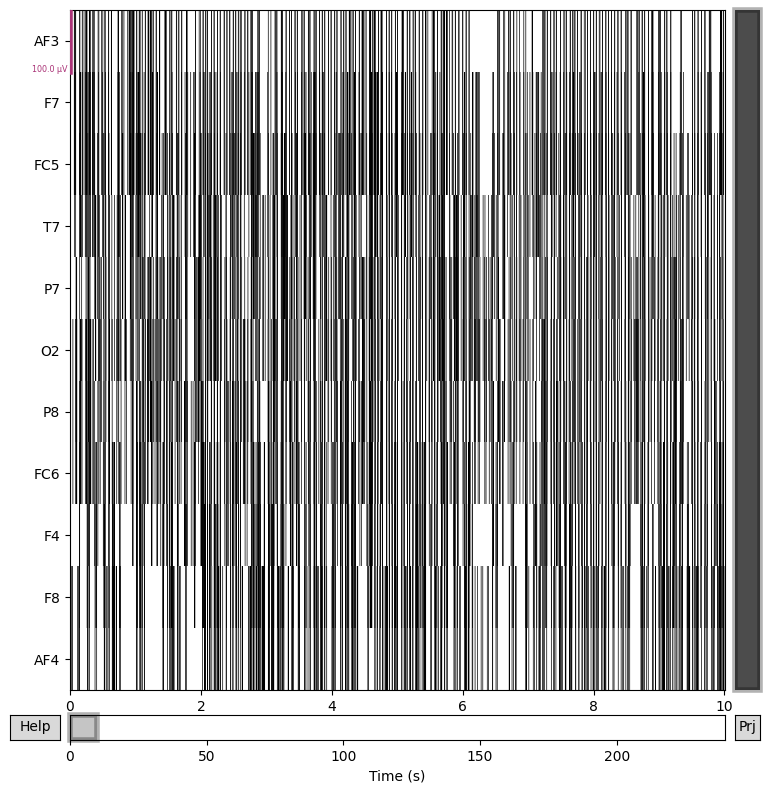

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
30670  False  False  False  False  False  False  False  False  False  False   
30671  False  False  False  False  False  False  False  False  False  False   
30672  False  False  False  False  False  False  False  False  False  False   
30673  False  False  False  False  False  False  False  False  False  False   
30674  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


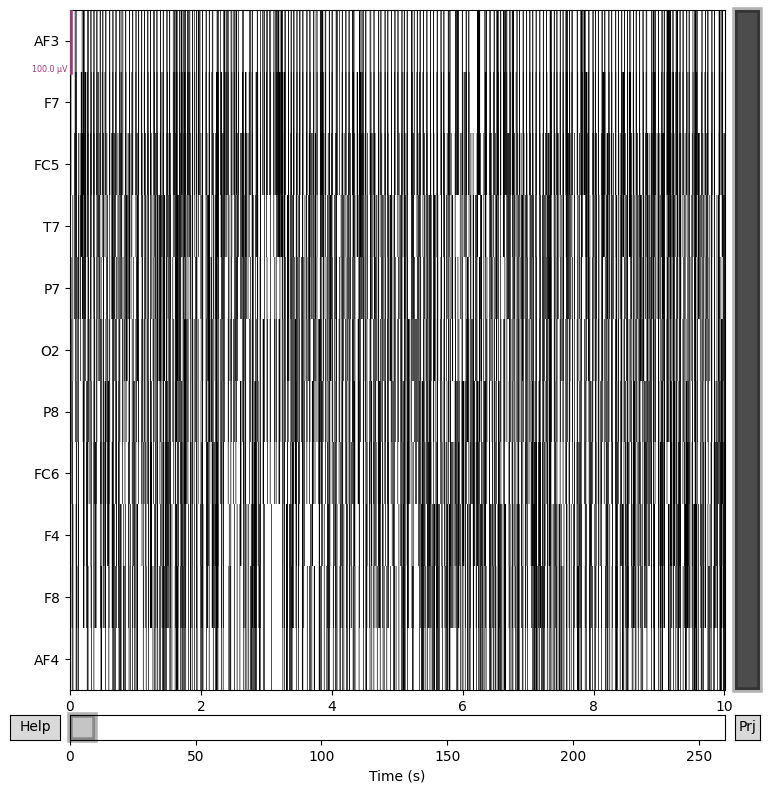

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
33332  False  False  False  False  False  False  False  False  False  False   
33333  False  False  False  False  False  False  False  False  False  False   
33334  False  False  False  False  False  False  False  False  False  False   
33335  False  False  False  False  False  False  False  False  False  False   
33336  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


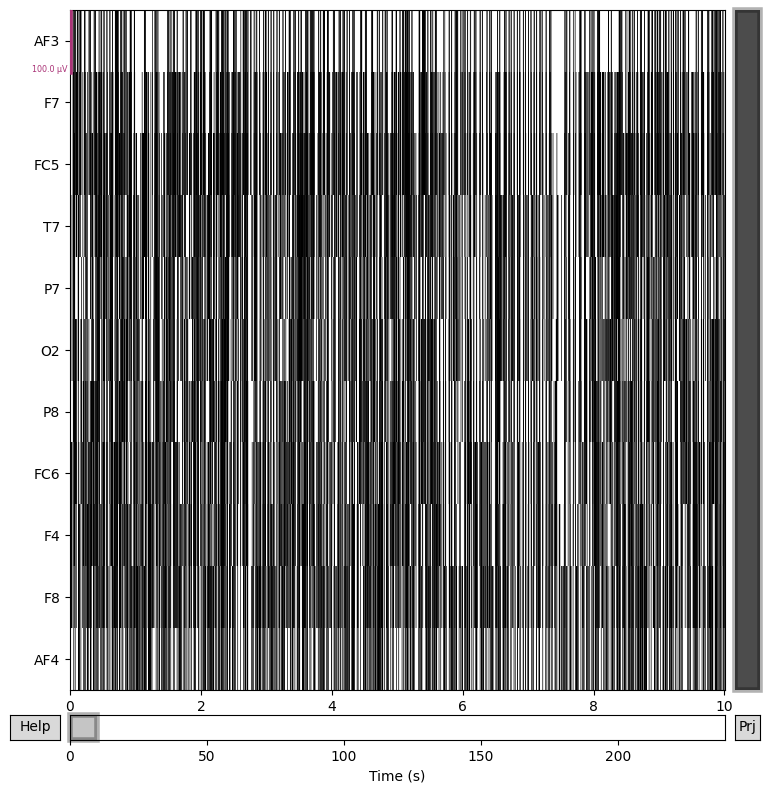

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
30613  False  False  False  False  False  False  False  False  False  False   
30614  False  False  False  False  False  False  False  False  False  False   
30615  False  False  False  False  False  False  False  False  False  False   
30616  False  False  False  False  False  False  False  False  False  False   
30617  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


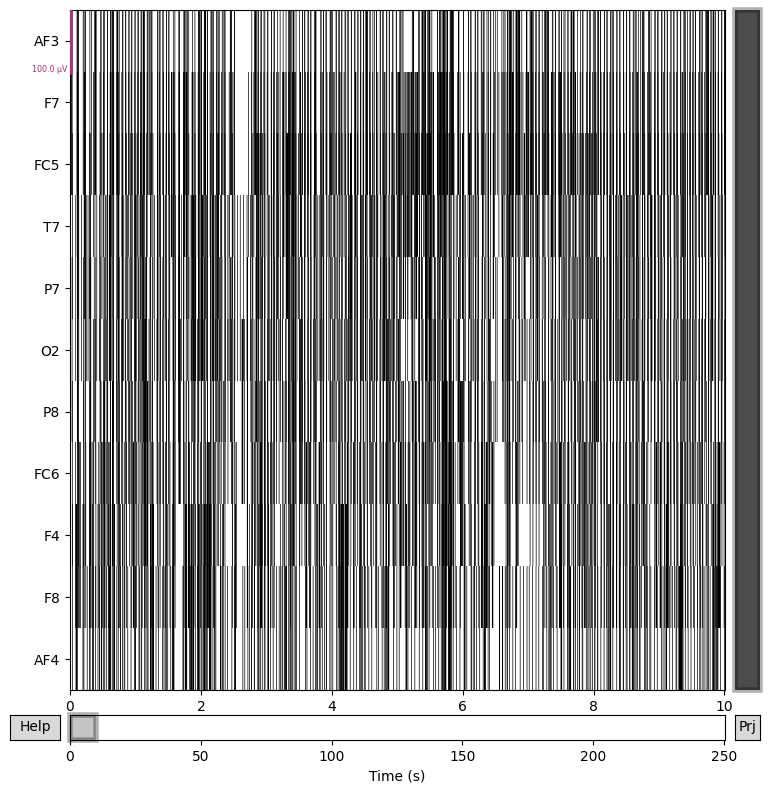

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
32050  False  False  False  False  False  False  False  False  False  False   
32051  False  False  False  False  False  False  False  False  False  False   
32052  False  False  False  False  False  False  False  False  False  False   
32053  False  False  False  False  False  False  False  False  False  False   
32054  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


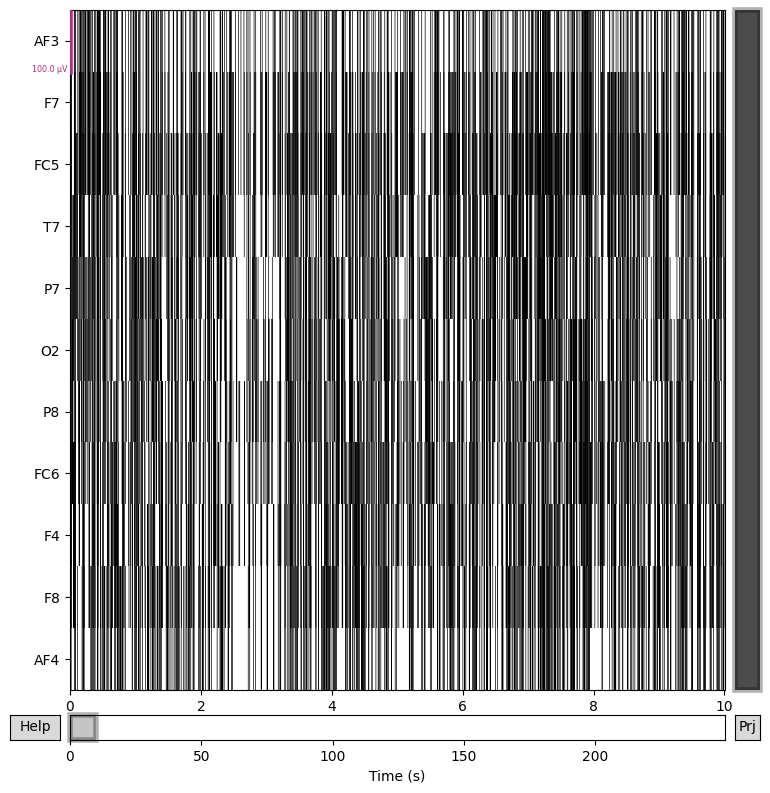

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
31934  False  False  False  False  False  False  False  False  False  False   
31935  False  False  False  False  False  False  False  False  False  False   
31936  False  False  False  False  False  False  False  False  False  False   
31937  False  False  False  False  False  False  False  False  False  False   
31938  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


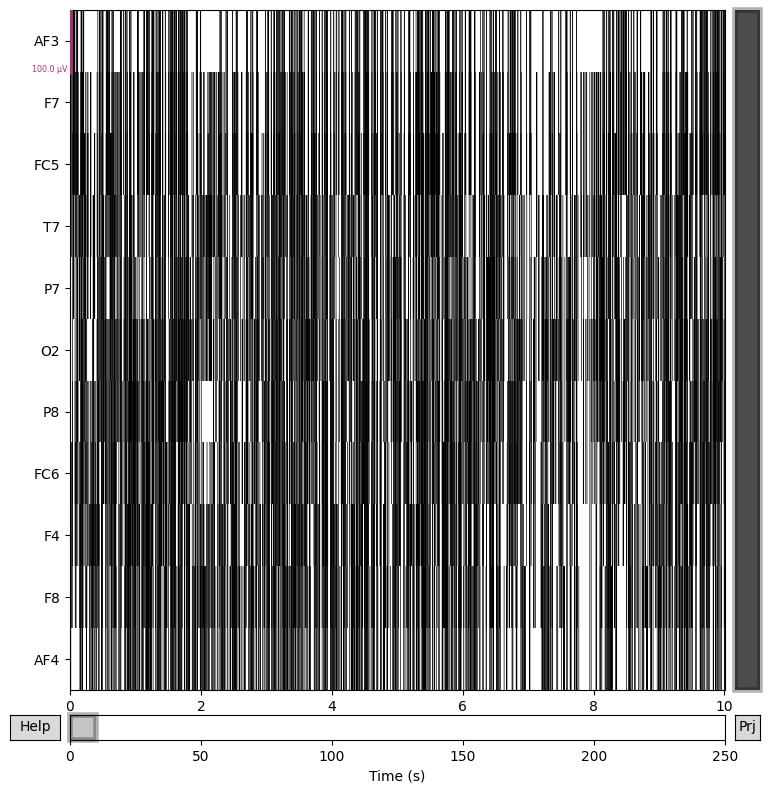

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
32009  False  False  False  False  False  False  False  False  False  False   
32010  False  False  False  False  False  False  False  False  False  False   
32011  False  False  False  False  False  False  False  False  False  False   
32012  False  False  False  False  False  False  False  False  False  False   
32013  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


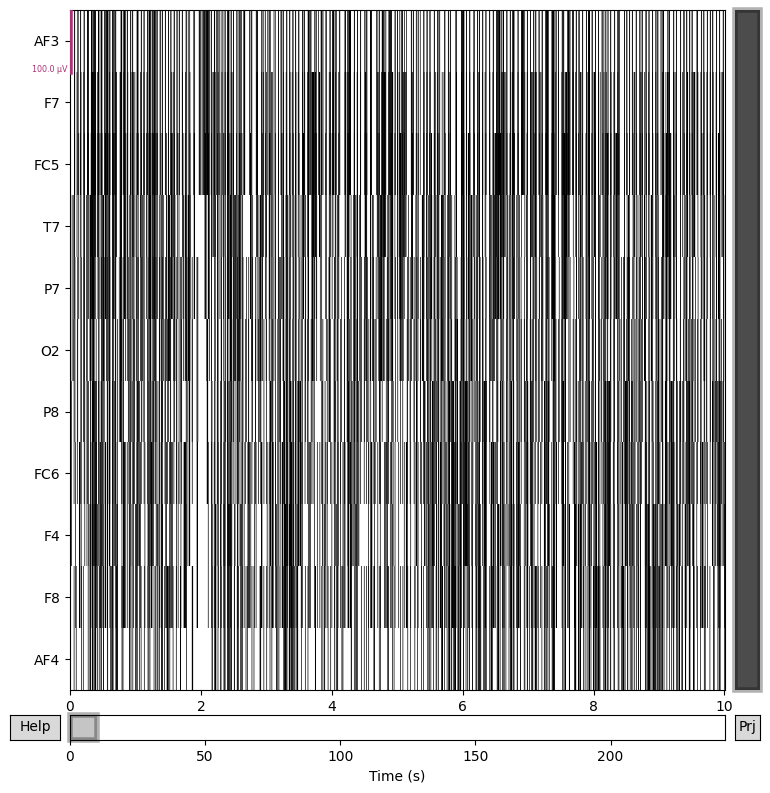

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
31013  False  False  False  False  False  False  False  False  False  False   
31014  False  False  False  False  False  False  False  False  False  False   
31015  False  False  False  False  False  False  False  False  False  False   
31016  False  False  False  False  False  False  False  False  False  False   
31017  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)
<ipython-input-41-8317d308dc10>:6: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels


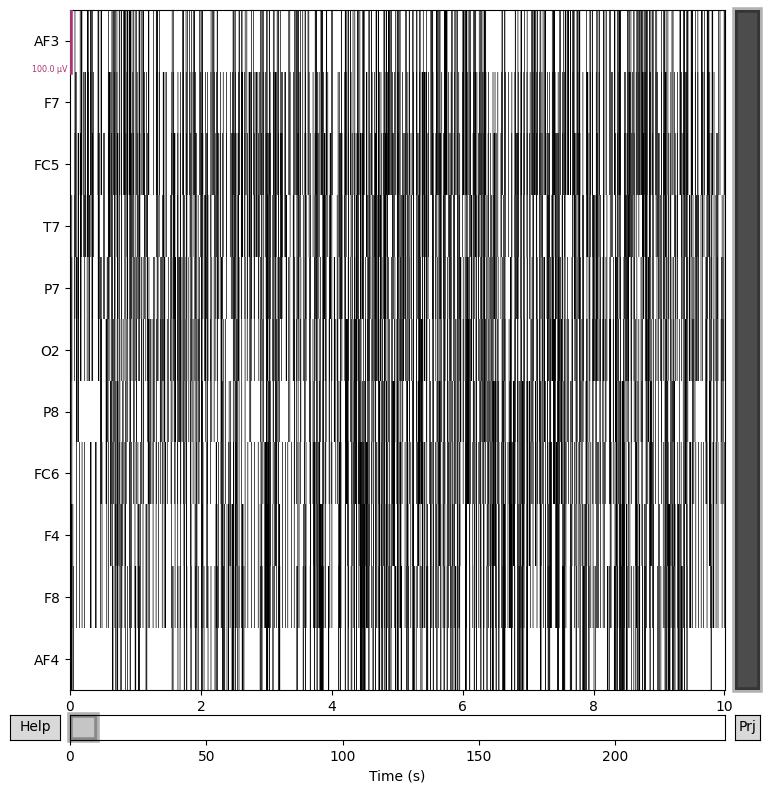

NaN values found in the following locations:
         AF3     F7    FC5     T7     P7     O2     P8    FC6     F4     F8  \
0      False  False  False  False  False  False  False  False  False  False   
1      False  False  False  False  False  False  False  False  False  False   
2      False  False  False  False  False  False  False  False  False  False   
3      False  False  False  False  False  False  False  False  False  False   
4      False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
30734  False  False  False  False  False  False  False  False  False  False   
30735  False  False  False  False  False  False  False  False  False  False   
30736  False  False  False  False  False  False  False  False  False  False   
30737  False  False  False  False  False  False  False  False  False  False   
30738  False  False  False  False  False  False  False  False  False  False   

      

<ipython-input-41-8317d308dc10>:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')
<ipython-input-41-8317d308dc10>:34: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_cleaned.interpolate_bads(reset_bads=True)


In [41]:
# Interpolation and NaN handling for Raw objects after ICA and filtering
def interpolate_and_handle_nans(raw_cleaned):
    try:
        # Step 1: Interpolate bad channels
        bad_channels = raw_cleaned.info['bads']
        raw_cleaned.interpolate_bads(reset_bads=True)  # Interpolate bad channels
        raw_cleaned.plot(n_channels=12, scalings=dict(eeg=50e-6))

        # Step 2: Handle NaN values in the EEG data
        eeg_data = pd.DataFrame(raw_cleaned.get_data().T, columns=raw_cleaned.ch_names)
        nan_locations = eeg_data.isna()

        # Print locations of NaN values
        print("NaN values found in the following locations:")
        print(nan_locations)

        # Step 3: Interpolate NaN values in the EEG data
        eeg_data_interpolated = eeg_data.interpolate(method='linear', axis=0)

        # Step 4: Check if any NaN values remain after interpolation
        nan_check = eeg_data_interpolated.isna().sum()
        print("Remaining NaN values after interpolation per column:")
        print(nan_check)

        # Step 5: Replace remaining NaNs with forward fill or backward fill
        eeg_data_interpolated = eeg_data_interpolated.fillna(method='ffill').fillna(method='bfill')

        # Final check for remaining NaN values
        remaining_nans = eeg_data_interpolated.isna().sum()
        print(f"Remaining NaN values after interpolation: {remaining_nans}")

        # Step 6: Mark and interpolate bad channels in the Raw object
        raw_cleaned.info['bads'] = [ch for ch in bad_channels if ch in raw_cleaned.info['ch_names']]
        raw_cleaned.interpolate_bads(reset_bads=True)

        # Update Raw object with interpolated EEG data
        raw_cleaned = mne.io.RawArray(eeg_data_interpolated.T.to_numpy(), raw_cleaned.info)
        return raw_cleaned
    except Exception as e:
        print(f"Error during interpolation and NaN handling: {e}")
        return raw_cleaned

# Dictionary to store the cleaned Raw objects after interpolation and NaN handling
interpolated_raw_word_data = {}

# Process each Raw object for interpolation and NaN handling
for word, raw_object in cleaned_raw_word_data.items():
    print(f"\nProcessing Raw object for word: {word}")

    try:
        # Apply interpolation and NaN handling
        raw_cleaned = interpolate_and_handle_nans(raw_object)

        # Store the cleaned Raw object after interpolation and NaN handling
        interpolated_raw_word_data[word] = raw_cleaned
        print(f"Successfully processed and cleaned Raw object for word: {word}")

    except Exception as e:
        print(f"Failed to process Raw object for word {word}: {e}")


In [42]:
# Function to apply Z-score normalization to EEG data
def z_score_normalize_eeg_data(raw):
    """
    Normalize the EEG data in the Raw object using Z-score normalization
    (zero mean, unit variance).
    """
    eeg_data = raw.get_data()  # Extract EEG data
    mean = np.mean(eeg_data, axis=1, keepdims=True)  # Compute the mean for each channel
    std = np.std(eeg_data, axis=1, keepdims=True)    # Compute the standard deviation for each channel

    # Z-score normalization
    normalized_data = (eeg_data - mean) / std

    # Replace the data in the Raw object with normalized data
    raw._data = normalized_data
    print("Applied Z-score normalization (zero mean, unit variance).")
    return raw

# Dictionary to store Z-score normalized Raw objects
z_score_normalized_raw_word_data = {}

# Process each interpolated Raw object to apply Z-score normalization
for word, raw_object in interpolated_raw_word_data.items():
    print(f"\nApplying Z-score normalization to Raw object for word: {word}")

    try:
        # Normalize the Raw object
        z_score_normalized_raw = z_score_normalize_eeg_data(raw_object)

        # Store the Z-score normalized Raw object
        z_score_normalized_raw_word_data[word] = z_score_normalized_raw
        print(f"Successfully applied Z-score normalization for word: {word}")

    except Exception as e:
        print(f"Failed to apply Z-score normalization for word {word}: {e}")

# Example: Inspect Z-score normalization for a specific word
target_word = 'اسفل'
if target_word in z_score_normalized_raw_word_data:
    raw = z_score_normalized_raw_word_data[target_word]
    data = raw.get_data()
    print(f"Mean of Z-score normalized data for word {target_word}: {np.mean(data, axis=1)}")
    print(f"Standard deviation of Z-score normalized data for word {target_word}: {np.std(data, axis=1)}")
else:
    print(f"word {target_word} not found in Z-score normalized data.")



Applying Z-score normalization to Raw object for word: نعم
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for word: نعم

Applying Z-score normalization to Raw object for word: حمام
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for word: حمام

Applying Z-score normalization to Raw object for word: يمين
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for word: يمين

Applying Z-score normalization to Raw object for word: جوع
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for word: جوع

Applying Z-score normalization to Raw object for word: مسافة
Applied Z-score normalization (zero mean, unit variance).
Successfully applied Z-score normalization for word: مسافة

Applying Z-score normalization to Raw object for word: يسار
Applied Z-score normalization (zero mean, unit variance)

In [43]:
# Define the segment length in seconds
SEGMENT_LENGTH_SECONDS = 2  # Duration of each segment
segment_length = FS * SEGMENT_LENGTH_SECONDS  # Number of rows per segment

# Dictionary to store segmented data for each word
segmented_word_data = {}

# Iterate through each word and its RawArray data
for word, raw_data in interpolated_raw_word_data.items():
    print(f"Segmenting data for word: {word}")

    if isinstance(raw_data, mne.io.RawArray):
        # Extract raw numerical data
        data = raw_data.get_data().T
        num_segments = len(data) // segment_length

        # Create segments
        segments = [
            data[i * segment_length: (i + 1) * segment_length]
            for i in range(num_segments)
        ]

        # Optional: Handle partial segment
        if len(data) % segment_length != 0:
            partial_segment = data[num_segments * segment_length:]
            print(f"Partial segment for {word} with length {len(partial_segment)}")

        # Store the segments
        segmented_word_data[word] = segments
        print(f"  {len(segments)} full segments created for word {word}")
    else:
        print(f"Unsupported data type for word {word}: {type(raw_data)}")
        continue

# Iterate through each word and its segmented data
for word, segments in segmented_word_data.items():
    # Convert list of numpy arrays into a single DataFrame
    flat_segments = []
    for i, segment in enumerate(segments):
        # Flatten each segment and add a segment ID (optional)
        segment_df = pd.DataFrame(segment)
        segment_df['Segment_ID'] = i
        flat_segments.append(segment_df)

    # Combine all segments into one DataFrame
    df = pd.concat(flat_segments, ignore_index=True)

    # Save the DataFrame to a CSV
    save_path = os.path.join('/content/drive/MyDrive/preprocessed words', f"{word}_segmented_data.csv")
    df.to_csv(save_path, index=False)
    print(f"Saved {word} segmented data to {save_path}")





Segmenting data for word: نعم
Partial segment for نعم with length 191
  119 full segments created for word نعم
Segmenting data for word: حمام
Partial segment for حمام with length 17
  124 full segments created for word حمام
Segmenting data for word: يمين
Partial segment for يمين with length 103
  124 full segments created for word يمين
Segmenting data for word: جوع
Partial segment for جوع with length 107
  114 full segments created for word جوع
Segmenting data for word: مسافة
Partial segment for مسافة with length 233
  109 full segments created for word مسافة
Segmenting data for word: يسار
Partial segment for يسار with length 187
  135 full segments created for word يسار
Segmenting data for word: عطش
Partial segment for عطش with length 169
  124 full segments created for word عطش
Segmenting data for word: حذف
Partial segment for حذف with length 196
  112 full segments created for word حذف
Segmenting data for word: لا
Partial segment for لا with length 211
  119 full segments created fo

In [44]:
#CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense


# Constants
NUM_CHANNELS = 12  # Number of EEG channels
NUM_CLASSES = len(segmented_word_data.keys())  # Number of unique words

# Step 1: Prepare data for LSTM
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        # Append the numpy array directly and ensure correct shape for LSTM
        X.append(segment)  # Assuming `segment` is already a numpy array
        y.append(word)  # The word is the target label


X = np.array(X)  # Shape: (number_of_segments, segment_length, NUM_CHANNELS)
y = np.array(y)  # Shape: (number_of_segments,)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the CNN model
cnn_model = create_cnn_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
cnn_model.summary()

cnn_history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


# Evaluate the model
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions on test data
y_pred_probs = cnn_model.predict(X_test)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=-1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=-1)  # True class indices

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 254, 64)             │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 125, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1984)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │         127,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,432 (532.94 KB)

 Trainable params: 136,432 (532.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.0887 - loss: 2.8391 - val_accuracy: 0.1350 - val_loss: 2.6896
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1439 - loss: 2.6076 - val_accuracy: 0.2733 - val_loss: 2.3635
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3030 - loss: 2.1611 - val_accuracy: 0.4116 - val_loss: 1.9121
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4316 - loss: 1.7247 - val_accuracy: 0.5916 - val_loss: 1.5327
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5283 - loss: 1.4239 - val_accuracy: 0.6334 - val_loss: 1.2341
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6222 - loss: 1.1118 - val_accuracy: 0.7170 - val_loss: 0.9652
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7025 - loss: 0.8940 - val_accuracy: 0.7621 - val_loss: 0.7499
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7615 - loss: 0.7034 - val_accuracy: 0.8071 - val_loss

In [45]:
#CNN and LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Flatten, Dense

# Constants
NUM_CHANNELS = 11  # Number of EEG channels
NUM_CLASSES = len(segmented_word_data.keys())  # Number of unique words

# Step 1: Prepare data for CNN + LSTM
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        X.append(segment)  # Assuming `segment` is already a numpy array
        y.append(word)  # The word is the target label


X = np.array(X)  # Shape: (number_of_segments, segment_length, NUM_CHANNELS)
y = np.array(y)  # Shape: (number_of_segments,)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the CNN + LSTM model
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    # CNN layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # LSTM layers
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the CNN + LSTM model
cnn_lstm_model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
cnn_lstm_model.summary()

cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions on test data
y_pred_probs = cnn_lstm_model.predict(X_test)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=-1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=-1)  # True class indices

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 254, 64)             │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 127, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 125, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 62, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 62, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,752 (190.44 KB)

 Trainable params: 48,752 (190.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.0730 - loss: 2.7736 - val_accuracy: 0.1543 - val_loss: 2.7026
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1349 - loss: 2.6485 - val_accuracy: 0.1833 - val_loss: 2.3739
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1965 - loss: 2.2999 - val_accuracy: 0.3151 - val_loss: 1.9655
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2997 - loss: 1.9834 - val_accuracy: 0.3441 - val_loss: 1.8112
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3454 - loss: 1.7799 - val_accuracy: 0.3987 - val_loss: 1.5825
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4458 - loss: 1.5522 - val_accuracy: 0.4823 - val_loss: 1.4662
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4761 - loss: 1.4556 - val_accuracy: 0.4952 - val_loss: 1.2621
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5378 - loss: 1.2798 - val_accuracy: 0.5370 - v

In [46]:
#EEGNet
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, SpatialDropout2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Constants
NUM_CHANNELS = 11
NUM_CLASSES = len(segmented_word_data.keys())

# Preparing Data
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        X.append(segment)
        y.append(word)  # The word is the target label

X = np.array(X)
y = np.array(y)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Adjusting the input shape for Conv2D (Add channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
input_shape = X_train.shape[1:]  # (segment_length, NUM_CHANNELS, 1)


# EEGNet Model
def create_eegnet(input_shape, num_classes):
    F1, F2, kernLength, dropoutRate = 16, 32, 64, 0.3

    input1 = Input(shape=input_shape)
    block1 = Conv2D(F1, (kernLength, 1), padding='same', use_bias=False)(input1)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((1, NUM_CHANNELS), use_bias=False, depth_multiplier=2)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = SpatialDropout2D(dropoutRate)(block1)
    block1 = AveragePooling2D((4, 1))(block1)

    block2 = SeparableConv2D(F2, (16, 1), padding='same', use_bias=False)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((8, 1))(block2)

    # SE Block
    filters = block2.shape[-1]
    se = GlobalAveragePooling2D()(block2)
    se = Dense(filters // 8, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    block2 = Multiply()([block2, se])

    flatten = Flatten()(block2)
    dense = Dense(num_classes, activation='softmax')(flatten)

    return Model(inputs=input1, outputs=dense)

# Model Creation
eegnet_model = create_eegnet(input_shape, NUM_CLASSES)
eegnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
epochs = 20
batch_size = 32
history = eegnet_model.fit(X_train, y_train, validation_split=0.2,
                           epochs=epochs, batch_size=batch_size,
                           callbacks=[early_stopping], verbose=1)

# Test Set Evaluation
test_loss, test_acc = eegnet_model.evaluate(X_test, y_test, verbose=0)
y_true_labels = np.argmax(eegnet_model.predict(X_test), axis=1)
y_pred_labels = np.argmax(y_test, axis=1)

# Print Results
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.0689 - loss: 2.7983 - val_accuracy: 0.0418 - val_loss: 2.7734
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1199 - loss: 2.6815 - val_accuracy: 0.0418 - val_loss: 2.7751
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2165 - loss: 2.5069 - val_accuracy: 0.0386 - val_loss: 2.7733
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3454 - loss: 2.2073 - val_accuracy: 0.0450 - val_loss: 2.7562
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3798 - loss: 1.9119 - val_accuracy: 0.0547 - val_loss: 2.6916
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5409 - loss: 1.4438 - val_accuracy: 0.0643 - val_loss: 2.6339
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6624 - loss: 1.1048 - val_accuracy: 0.1222 - val_loss: 2.4055
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7687 - loss: 0.8284 - val_accuracy: 0.3280 - v

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Constants
NUM_CHANNELS = 11  # Number of EEG channels
NUM_CLASSES = len(segmented_word_data.keys())  # Number of unique words

# Step 1: Prepare data for BiLSTM
X = []  # Features
y = []  # Labels

for word, segments in segmented_word_data.items():
    for segment in segments:
        X.append(segment)  # Assuming `segment` is already a numpy array
        y.append(word)  # The word is the target label

X = np.array(X)  # Shape: (number_of_segments, segment_length, NUM_CHANNELS)
y = np.array(y)  # Shape: (number_of_segments,)

# Encode labels to integers and one-hot encode them
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert words to integers
y_one_hot = to_categorical(y_encoded, num_classes=NUM_CLASSES)  # One-hot encoding

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Define the BiLSTM model
def create_bilstm_model(input_shape, num_classes):
    model = Sequential()

    # BiLSTM layers
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.3))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the BiLSTM model
bilstm_model = create_bilstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])
bilstm_model.summary()

bilstm_history = bilstm_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss, accuracy = bilstm_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions on test data
y_pred_probs = bilstm_model.predict(X_test)  # Predicted probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=-1)  # Predicted class indices
y_true_labels = np.argmax(y_test, axis=-1)  # True class indices

# Print example predictions
print("\nExample Predictions:")
for i in range(5):  # Print first 5 examples
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_12 (Bidirectional)     │ (None, 256, 256)            │         143,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 256, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 256, 128)            │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 256, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 16)                  │           1,040 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,128 (1.35 MB)

 Trainable params: 354,128 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.0817 - loss: 2.7583 - val_accuracy: 0.0965 - val_loss: 2.7147
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.1447 - loss: 2.6673 - val_accuracy: 0.2026 - val_loss: 2.4828
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.1861 - loss: 2.4074 - val_accuracy: 0.2283 - val_loss: 2.2017
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.2947 - loss: 2.1121 - val_accuracy: 0.2990 - val_loss: 2.1096
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.3053 - loss: 1.9438 - val_accuracy: 0.3280 - val_loss: 1.8640
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.3729 - loss: 1.7396 - val_accuracy: 0.4823 - val_loss: 1.4816
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5174 - loss: 1.3938 - val_accuracy: 0.5949 - val_loss: 1.2510
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5257 - loss: 1.2876 - val_accuracy: 0.5434 -